### Feature Engineering Outlier handling

Topics covered are below:
1. Trimming outliers from the dataset
2. Performing winsorization
3. Capping the variable at arbitrary maximum and minimum values
4. Performing zero-coding – capping the variable values at zero

### Trimming outliers from the dataset

Trimming, or truncating, is the process of removing observations that show outliers in one
or more variables in the dataset. There are three commonly used methods to set the
boundaries beyond which a value can be considered an outlier. If the variable is normally
distributed, the boundaries are given by the mean plus or minus three times the standard
deviation, as approximately 99% of the data will be distributed between those limits. For
normally, as well as not normally, distributed variables, we can determine the limits using
the inter-quartile range proximity rules or by directly setting the limits to the 5th and 95th
quantiles.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_boston
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
boston_dataset = load_boston()

In [5]:
boston = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)[['RM', 'LSTAT', 'CRIM']]
boston

,RM,LSTAT,CRIM
0,6.575,4.98,0.00632
1,6.421,9.14,0.02731
2,7.185,4.03,0.02729
3,6.998,2.94,0.03237
4,7.147,5.33,0.06905
...,...,...,...
501,6.593,9.67,0.06263
502,6.120,9.08,0.04527
503,6.976,5.64,0.06076
504,6.794,6.48,0.10959


<AxesSubplot:xlabel='RM', ylabel='Density'>

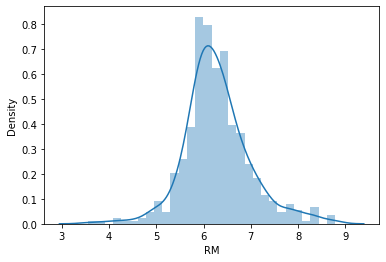

In [6]:
sns.distplot(boston['RM'], bins=30)

<AxesSubplot:xlabel='RM'>

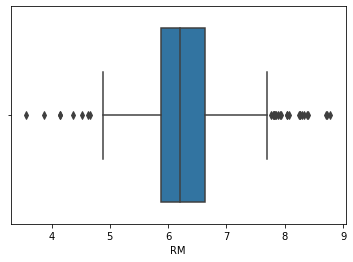

In [7]:
sns.boxplot(boston['RM'])

In [8]:
#function for defing IQR and retun boundaries
def find_boundaries(df, variable, distance):
    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)
    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)
    return upper_boundary, lower_boundary

In [9]:
RM_upper_limit, RM_lower_limit = find_boundaries(boston, 'RM', 1.5)

In [20]:
LSTAT_upper_limit, LSTAT_lower_limit = find_boundaries(boston, 'LSTAT',1.5)

In [22]:
CRIM_upper_limit, CRIM_lower_limit  = find_boundaries(boston,'CRIM',1.5)

In [10]:
RM_upper_limit, RM_lower_limit

(7.730500000000001, 4.778499999999999)

In [18]:
outliers_RM = np.where(boston['RM'] > RM_upper_limit, True,
                       np.where(boston['RM'] < RM_lower_limit, True, False))



In [21]:
outliers_LSTAT = np.where(boston['LSTAT'] > LSTAT_upper_limit, True,
                       np.where(boston['LSTAT'] < LSTAT_lower_limit, True, False))

In [23]:
outliers_CRIM = np.where(boston['CRIM'] > CRIM_upper_limit, True,
                       np.where(boston['CRIM'] < CRIM_lower_limit, True, False))

In [24]:
boston_trimmed1 = boston.loc[~(outliers_RM)]


In [26]:
boston_trimmed1

,RM,LSTAT,CRIM
0,6.575,4.98,0.00632
1,6.421,9.14,0.02731
2,7.185,4.03,0.02729
3,6.998,2.94,0.03237
4,7.147,5.33,0.06905
...,...,...,...
501,6.593,9.67,0.06263
502,6.120,9.08,0.04527
503,6.976,5.64,0.06076
504,6.794,6.48,0.10959


<AxesSubplot:xlabel='RM'>

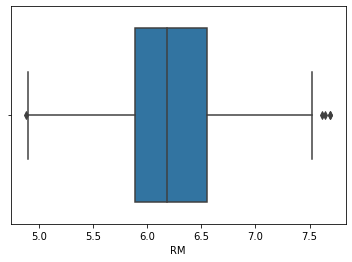

In [27]:
sns.boxplot(boston_trimmed1['RM'])

In [28]:
#Wecan also perform following ways
def find_boundaries1(df, variable, distance):
    lower_boundary = df[variable].mean() - (df[variable].std() *distance)
    upper_boundary = df[variable].mean() + (df[variable].std() *distance)
    return upper_boundary, lower_boundary

In [29]:
def find_boundaries2(df, variable):
    lower_boundary = df[variable].quantile(0.05)
    upper_boundary = df[variable].quantile(0.95)
    return upper_boundary, lower_boundary

In [30]:
boston_trimmed2 = boston.loc[~(outliers_RM + outliers_LSTAT + outliers_CRIM)]

### Performing winsorization

Winsorization, or winsorizing, is the process of transforming the data by limiting the
extreme values, that is, the outliers, to a certain arbitrary value, closer to the mean of the
distribution. Winsorizing is different from trimming because the extreme values are not
removed, but are instead replaced by other values. A typical strategy involves setting
outliers to a specified percentile.

In [32]:
def winsorize(df, variable, upper_limit, lower_limit):
    return np.where(df[variable] > upper_limit, upper_limit,np.where(df[variable] < lower_limit, lower_limit,df[variable]))

In [33]:
boston['RM']= winsorize(boston, 'RM', boston['RM'].quantile(0.95),
boston['RM'].quantile(0.05))

<AxesSubplot:xlabel='RM'>

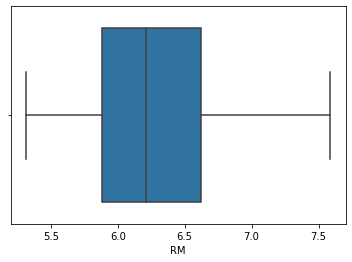

In [34]:
sns.boxplot(boston['RM'])

In [35]:
#using feature engineering 
#from feature_engine.outlier_removers import Winsorizer
#windsorizer = Winsorizer(distribution='quantiles', tail='both', variables=['RM', 'LSTAT', 'CRIM'])
#windsorizer.fit(boston)
#boston_t = windsorizer.transform(boston)
#windsorizer.right_tail_caps_


### Capping the variable at arbitrary maximum and minimum values

Similarly to winsorization, we can replace the extreme values by values closer to other
values in the variable, by determining the maximum and minimum boundaries with the
mean plus or minus the standard deviation, or the inter-quartile range proximity rule. This
procedure is also called bottom and top coding, censoring, or capping. We can cap both
extremes of the distribution or just one of the tails, depending on where we find the outliers
in the variable. In this recipe, we will replace extreme values by the mean and standard
deviation or the inter-quartile range proximity rule, using pandas, NumPy, and Featureengine, and using the Boston House Prices dataset from scikit-learn.

In [38]:
def find_skewed_boundaries(df, variable, distance):
    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)
    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)
    return upper_boundary, lower_boundary


In [39]:
#make a function to find the limits using the mean and the standard deviation
def find_normal_boundaries(df, variable, distance):
    upper_boundary = df[variable].mean() + distance *df[variable].std()
    lower_boundary = df[variable].mean() - distance *df[variable].std()
    return upper_boundary, lower_boundary

In [40]:
RM_upper_limit, RM_lower_limit = \
find_normal_boundaries(boston, 'RM', 3)
LSTAT_upper_limit, LSTAT_lower_limit = \
find_normal_boundaries(boston, 'LSTAT', 3)
CRIM_upper_limit, CRIM_lower_limit = \
find_normal_boundaries(boston, 'CRIM', 3)

In [41]:
boston['RM']= np.where(boston['RM'] > RM_upper_limit,
 RM_upper_limit,
 np.where(boston['RM'] < RM_lower_limit,
 RM_lower_limit, boston['RM']))

In [42]:
#using feature engineering

In [44]:
#from feature_engine.outlier_removers import Winsorizer

In [45]:
#windsorizer = Winsorizer(distribution='gaussian', tail='both',fold=3, variables=['RM', 'LSTAT', 'CRIM'])

In [46]:
#windsorizer.fit(boston)

In [47]:
#boston_t = windsorizer.transform(boston)

### Performing zero-coding – capping the variable at zero

In econometrics and statistics, top-coding and bottom-coding refer to the act of censoring
data points, the values of which are above or below a certain number or threshold,
respectively. In essence, top and bottom coding is what we have covered in the previous
recipe, where we capped the minimum or maximum values of variables at a certain value,
which we determined with the mean and standard deviation, the inter-quartile range
proximity rule, or the percentiles. Zero-coding is a variant of bottom-coding and refers to
the process of capping, usually the lower value of the variable, at zero. It is commonly used
for variables that cannot take negative values, such as age or income. In this recipe, we will
learn how to implement zero-coding in a toy dataframe using pandas and Feature-engine.

In [48]:
np.random.seed(29) # for reproducibility

n = 200 # in the book we pass directly 200 within brackets, without defining n
x = np.random.randn(n) + 2
y = np.random.randn(n) * 2 + 4
z = np.random.randn(n) * 5 + 10

data = pd.DataFrame([x, y, z]).T
data.columns = ['x', 'y', 'z']

data.head()

,x,y,z
0,1.582518,6.903260,9.695655
1,2.706032,4.930279,14.363733
2,3.915985,4.688840,15.803355
3,-0.141755,3.488652,17.403682
4,2.719057,2.388501,20.859069


In [49]:
data.min()

x   -1.505401
y   -0.901451
z   -1.552986
dtype: float64

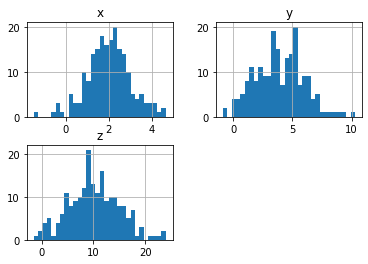

In [50]:
data.hist(bins=30)
plt.show()

In [51]:
data.loc[data['x'] < 0, 'x'] = 0
data.loc[data['y'] < 0, 'y'] = 0
data.loc[data['z'] < 0, 'z'] = 0

data.min()

x    0.0
y    0.0
z    0.0
dtype: float64

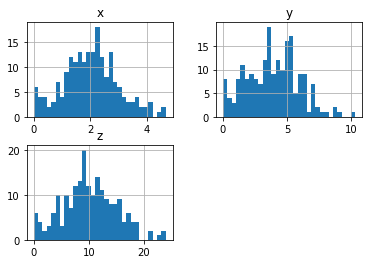

In [52]:
data.hist(bins=30)
plt.show()

### Zero coding with feature-engine

In [53]:
#from feature_engine.outlier_removers import ArbitraryOutlierCapper#

In [54]:
#windsorizer = ArbitraryOutlierCapper(max_capping_dict=None, min_capping_dict={'x':0, 'y':0, 'z':0})


In [55]:
#windsorizer.fit(data)
#data_t = windsorizer.transform(data)

### Thank You